In [1]:
שלבים בעבודה:
    1. לקרוא את כל קובץ המשימות וללמוד את הרקע טוב
    2. להתמצא בקישורים הנוספים שצורפו
    3. לפתוח את קבצי הטיף בפייתון, להבין מה המבנה שלהם ובכלל באופן בסיסי איך אפשר לעבוד איתם
    4. לחשוב על סוגי מודלים לקלסיפיקציה שאני רוצה להשתמש בהם, חשוב שאני אכיר אותם ואדע למה דווקא הם ואכיר אופציות נוספות שלא בחרתי בהם
    5. הכנת הנתונים לאימון המודל
    6. אימון המודל...
    7. שאלה שנייה: לזהות את הזמן בו נעלם היער, בעצם עבור פוליגון נתון, צריך ליישם את המודל כדי להבין מתי יש ומתי אין בו יער, בשלב הבא לחלץ את התאריך בו קרה השינוי

SyntaxError: invalid syntax (1182963325.py, line 1)

# Imports

In [1]:
import os
import rasterio
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Explore the data

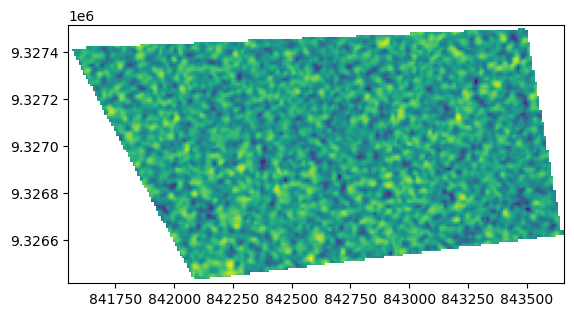

cordinate system EPSG:32720


In [24]:
from rasterio.plot import show

# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

directory = non_forest_dir
tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]

sardat = rasterio.open(tif_files[0])
show(sardat)
print(f'cordinate system {sardat.crs}')

# Data Loading and Preprocessing

#### Preparing Features and Labels

In [2]:
def load_tif_files(directory):
    """
    Load and return a list of arrays representing TIFF files from a directory.
    Each array will have a shape of (3, h, w) corresponding to the bands.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read()  # shape (3, h, w)
            bands_list.append(bands)
    
    return bands_list

# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

# Load all non-forest and forest files
non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)

print(f"Loaded {len(non_forest_data)} non-forest files and {len(forest_data)} forest files.")


Loaded 31 non-forest files and 45 forest files.


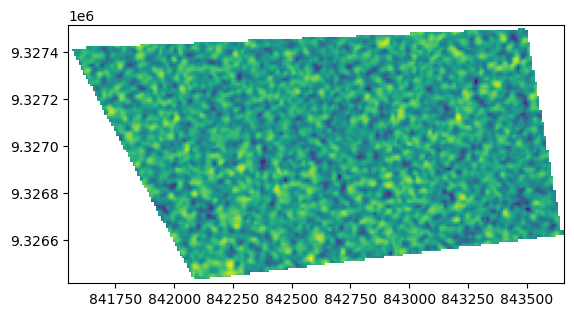

cordinate system EPSG:32720


In [3]:
def prepare_features_and_labels(non_forest_data, forest_data):
    """
    Prepare a feature matrix (X) and a label array (y) from the loaded TIFF data.
    Ensures the number of samples in X and y are consistent.
    """
    feature_list = []
    label_list = []
    
    # Process non-forest data
    for bands in non_forest_data:
        n_samples = bands.shape[1] * bands.shape[2]
        features = bands.reshape(3, n_samples).T  # shape (n_samples, 3)
        feature_list.append(features)
        labels = np.zeros(n_samples)  # Label 0 for non-forest
        label_list.append(labels)
    
    # Process forest data
    for bands in forest_data:
        n_samples = bands.shape[1] * bands.shape[2]
        features = bands.reshape(3, n_samples).T  # shape (n_samples, 3)
        feature_list.append(features)
        labels = np.ones(n_samples)  # Label 1 for forest
        label_list.append(labels)
    
    # Combine all features and labels into single arrays
    X = np.vstack(feature_list)
    y = np.hstack(label_list)
    
    return X, y

# Prepare features and labels
X_row, y_row = prepare_features_and_labels(non_forest_data, forest_data)

# Remove samples with NaN values
mask = ~np.isnan(X_row).any(axis=1)
X = X_row[mask]
y = y_row[mask]

no_nan_data_pct = (y.shape[0]/y_row.shape[0])*100
print(f"Number of data samples after cleaning nans: {y.shape[0]} which are {no_nan_data_pct}% from row data")

print(f"Feature matrix shape: {X.shape}, Labels shape: {y.shape}")


Number of data samples after cleaning nans: 20907341 which are 59.531860045149166% from row data
Feature matrix shape: (20907341, 3), Labels shape: (20907341,)


#### Data Splitting: Train, Validation, and Test Sets

In [10]:
# Split the data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle =True, random_state=42)

# Now split it to 50% validation, 50% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle =True, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 14635138 samples
Validation set size: 3136101 samples
Test set size: 3136102 samples


# Classification Method 1: Random Forest

In [7]:
# The model
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the Model
rf_classifier.fit(X_train, y_train)

print("Model training finished")


KeyboardInterrupt: 

### Validate the Model 

In [11]:
# Evaluate the model on the validation set
val_predictions = rf_classifier.predict(X_val)
val_accuracy = (val_predictions == y_val).mean()

print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.9939


### Test the Model

In [21]:
# Evaluate the final model on the test set
test_predictions = rf_classifier.predict(X_test)
test_accuracy = (test_predictions == y_test).mean()

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9938


### Visualization

In [1]:
# # Example: Preparing a mixed image (e.g., from non-forest or forest dataset) for classification
# example_bands = non_forest_data[0]  # Replace with actual image data
# n_samples = example_bands.shape[1] * example_bands.shape[2]
# example_features = example_bands.reshape(3, n_samples).T  # Flatten the image

# # Remove samples (pixels) with NaN values using the mask approach
# mask = ~np.isnan(example_features).any(axis=1)
# example_features_clean = example_features[mask]

# # Predict the forest/non-forest classification for each clean pixel
# predictions_clean = rf_classifier.predict(example_features_clean)

# # Create an empty array to hold the predictions, initialized with NaNs
# forest_mask = np.full(n_samples, np.nan)

# # Insert the predictions into the correct positions
# forest_mask[mask] = predictions_clean

# # Reshape the forest_mask back to the original image dimensions
# forest_mask = forest_mask.reshape(example_bands.shape[1], example_bands.shape[2])

# # Visualize the classification result
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.imshow(forest_mask, cmap='Greens')
# plt.title("Forest vs. Non-Forest Classification")
# plt.colorbar(label="0: Non-Forest, 1: Forest")
# plt.show()



## Feature Importance
# Get feature importances
importances = rf_classifier.feature_importances_
feature_names = ['VV', 'VH', 'Incidence Angle']

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importances in Random Forest Classifier")
plt.show()


NameError: name 'rf_classifier' is not defined